Status: ✅ Done

## 📓 Exercise 16

---

In this exercise, we will keep exploring `support vector machines`, and special focus will be put on its **soft margin version**. In the first section, we will again look at the theoretical concepts and then we will apply these concepts when visulizing soft margin SVM with different hyper-parameters.

> Imports

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_theme()
from mlxtend.plotting import plot_decision_regions

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import datasets

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings("ignore")

### 🏷 Soft margin SVM: theory

---

> Non-linear boundary

Real world data are messy, as such, it is rarely the case that we can find a perfect split in the original feature space. Recall how we dealt with such issues in the case of for instance logistic or linear regression, we simply added new features which were some sort of transformation of the input features. For instance, we might have simple logistic regression model:

$
f(x, y) = \sigma(ax + by + c)
$

As I mentioned, we might however encounter a problem such that there is no way we can find a line that would separate the given data points. For this reason, we might want to introduce a new non-linear feature based on on of the input features, e.g. $x^2$. Therefore, our model would be:

$
f(x, y) = \sigma(ax + by + cx^2 + d)
$

If we were to plot this in the original feature space, that is in 2D, we would obtain some non-linear boundary. But if we would instead treat the $x^2$ as a new possible input, then the model would be linear in this feature space (assuming $z = x^2$):

$
f(x, y, z) = \sigma(ax + by + cz + d)
$

And the same of course applies for `SVM`. Here I have found a nice [example](https://www.quora.com/Support-Vector-Machines-How-does-going-to-higher-dimension-help-data-get-linearly-separable-which-was-non-linearly-separable-in-actual-dimension) of when the given dataset is not separable in the given input space, but once we add a third variable based on the original feature(s), we can separate the datapoints by a plane.

You can find another example in this [geogebra note](https://www.geogebra.org/m/knd24xww). Here our decision boundary is defined as:

$
f(x_1, x_2) = \left(1+x_1\right)^2+\left(2-x_2\right)^2=4
$

If we expand the both parenthesis, then we get:

$
f(x_1, x_2) = 1 + x_1 + x_1^2 + 4 - 2x_2 + x_2^2 = 4
$

After bit more algebra we get:

$
f(x_1, x_2) = x_1  - 2x_2 + x_1^2 + x_2^2 = -1
$

Again, we can treat the non-linear variables based on the original input variables as individual variables such that:

$
f(x_1, x_2, x_3, x_4) = x_1 - 2x_2 + x_3 + x_4 = -1
$

where $x_3 = x_1^2$ and $x_4 = x_2^2$. That is why sometimes you hear people say that the given model is not linear in its feature space (the actual input), but rather it is linear in its parameters. (since each feature including those based on the actual input are assigned with a parameter that modifies the impact of the given variable on the overall model's output)

> Soft margin SVM (simple extension to the hard margin SVM)

Once you understand how hard margin SVM works, then soft margin should be fairly straighforward. Recall from the previous exercise, that in hard margin SVM we were looking for perfect separation of given datapoints. This was ensured by our constraint:

$
y_i\left(\mathrm{w} \cdot \mathrm{x}_{\mathrm{i}}+\mathrm{b}\right) \geq 1
$

But this of course means we overfit the given dataset which is suboptimal. This is further supported by the following image:

<img src="svm.png" alt="Paris" style="width:80%;height:80%;margin-left:auto;margin-right: auto">

So how can we **relax** this constraint? First, based on the above plot, we want to introduce some variable for each data point which would regularize how much is the model allowed to let the given data point cross the margin. This is because some datapoints are outliers, therefore it would be non-sense to have some one global variable. Let's define this variable as $\xi_i > 0$ and integrate it into our constraint as follows:

$
y_i\left(\mathrm{w} \cdot \mathrm{x}_{\mathrm{i}}+\mathrm{b}\right) \geq 1 - \xi_i

$

So what has changed? It can be nicely seen on the subplots 1 and 2. In the first subplot, we have hard margin, therefore, no point can be missclassified. In the second subplot, we have softmargin. Let me explain it on the example of the orange cross which is inside margins. We see that for **orange crosses on dotted line**, it holds the following true:

$
\left(\mathrm{w} \cdot \mathrm{x}_{\mathrm{i}}+\mathrm{b}\right) = 1
$

Once we reach the thick line, we get to the zero level curve, i.e., for all points on this line:

$
\left(\mathrm{w} \cdot \mathrm{x}_{\mathrm{i}}+\mathrm{b}\right) = 0
$

But the orange cross is actually even further than level curve 0, therefore the level curve there must be $< 0$. So what does this mean in terms of $\xi_i$ corresponding to the orange cross? Well, it must be large than one which would yield some negative number on the right side of this inequation:

$
\left(\mathrm{w} \cdot \mathrm{x}_{\text{orange cross}}+\mathrm{b}\right) \geq \text{negative number}
$

Thus, as I said in the beginning, by adding $\xi_i$ to our constraint we enable certain points to be misclassified. As you can see the, larger the $\xi_i$ is the more we relax the constraint about correct classification. Therefore in the third subplot, we can see that the orange cross is on a level curve which is probably some small negative number. So how does this effect our loss function? Let's see:

$
\begin{gathered}
\min _{w, b,\left\{\xi_i\right\}} \frac{1}{2}\|\mathrm{w}\|^2+C \sum_{i=1}^n \xi_i \\
\text { s.t. } \quad y_i\left(\mathrm{w} \cdot \mathrm{x}_{\mathrm{i}}+\mathrm{b}\right) \geq 1-\xi_i \quad i=1, \ldots, n \\
\xi_i \geq 0
\end{gathered}
$

The most essential is to look at the first line where we have a new term: $\sum_{i=1}^n \xi_i$. Note that the more the model **relaxes** the misclassification constraint, the higher number this term yields. Which is of course not good since we are trying to **minimize** the loss function. Therefore, this forces the model to relax the condition only if neccessary. In addition, we have also added new reguralization parameter $C$. This parameter has the following functionality:
- `high C`: means we make the model **stricter** - higher the $C$, the closer to the hard margin SVM, therefore less points get misclassified
- `low C`: the opposite of high $C$, i.e., more points get misclassified, the 'street' is broader 

Last but not the least, it is worth mentioning, that now the support vectors are not neccessary the vectors which are closest to the vectors from the other class, as it was in the case of hard margin SVM.

> Kernel trick

The above loss function is actual then translated to its **dual form**:

$
\begin{gathered}
\max _\alpha \quad \tilde{L}=\sum_i^n \alpha_i-\frac{1}{2} \sum_i^n \sum_j^n \alpha_i \alpha_j y_i y_j K\left(x_i, x_j\right) \\
\text { s.t. } \quad 0 \leq \alpha \leq C \quad \& \quad \sum_i^n \alpha_i y_i=0
\end{gathered}
$

The only difference between dual form of hard margin SVM and soft margin SVM is that now $\alpha$ has capped by the newly introduced hyper-parameter $C$, i. e., $\quad 0 \leq \alpha \leq C$. You might be wondering why can not we just optimize the initial loss function? Well, the main reason is that in **dual** form we have a interaction between the feature vectors done through **dot product between two vectors**. This **dot product** is denoted in the above equation as a function $K$ that takes two vectors as an input and returns their dot product. However, we could make this function $K$ more special - this is where **kernel functions** come into the picture and of course the **kernel trick**.

As we discussed in the previous subsection, in real life, it is neccessary to often add new non-linear features such that the input becomes linearly separable. The problem is that as we add new features, the more computational resources are needed to compute the dot product. Therefore, some smart people figured out that you can use **kernel function**, which takes as an input the original features, to output dot product between the given vectors as if they had many more dimension. For instance, let's say you have a **two dimensional input feature space**, but you add a new non-linear feature. This would mean that now you have to make dot-product between two vectors of size 3. Or you can use a kernel function that use your original 2 dimensional feature vectors, does some computation with them and the returned output represents dot-product as if the input were actually the 3 dimensional vectors. Luckily for us, these kernel functions are predefined, therefore, in practice you can just choose which one to use - you will see this in practice in the below section. If you want more about kernel functions, I think sklearn's [page](https://scikit-learn.org/stable/modules/kernel_approximation.html) about the subject is a good starting point.  

> Section summary

In this section, we discussed in depth:
- why does it make sense to add more non-linear features and why the model can still be viewed as linear
- why we need soft margin svm and how it actually extends the hard margin svm
- how we can compute dot product between high dimensional vectors more efficiently using kernel trick

Hopefully, after this section, you are able to answer all these questions 🤞

### 🏷 Soft margin SVM: practice

---

> Exploring different kernels and regularisation parameters

In this subsection, our goal will be to explore impact of different **kernel functions** as well as **reguralization parameter C** on classification of two different datasets:

In [9]:
# Some hyper-parameters for the datasets
n_samples = 200
noise = .005

# Binary classification of points which are shaped as circles
X1, y1 = datasets.make_circles(n_samples=n_samples, random_state = 42, noise = noise)

# Binary calssification of points which are shaped as moons
X2, y2 = datasets.make_moons(n_samples=n_samples, random_state = 42, noise = noise)

To visualize the impact of above mentioned variables on each respective dataset, I have written a `class` that should make it easy:

In [28]:
class VisualizeSVM:

    def __init__(self, X, y, kernels, C, figsize, name) -> None:
        self.X = X
        self.y = y
        self.kernels = kernels
        self.C = C
        self.figsize = figsize
        self.name = name

    def visualize(self):

        # Define a subplot
        fig, axs = plt.subplots(
            len(self.kernels), len(self.C), figsize=self.figsize)
        fig.subplots_adjust(wspace=0.5, hspace=.35);

        # Fit the models with different hyperparameters
        for i, kernel in enumerate(self.kernels):
            for j, c in enumerate(self.C):

                # Fit
                clf = make_pipeline(StandardScaler(), SVC(C=c, kernel=kernel))
                clf.fit(self.X, self.y)

                # Get relevant axes
                ax = axs[i][j]

                # Plotting decision regions
                plot_decision_regions(self.X, self.y, clf=clf, legend=2, ax=ax)

                # Adding axes annotations
                ax.set_title(f'{kernel} | C: {c}')
        
        # Save fig
        fig.savefig(self.name)

Before testing it out, we need to define the **test parameters**:

In [29]:
C = [.005, 25, 50, 100]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

Now, let's test it out for both datasets:

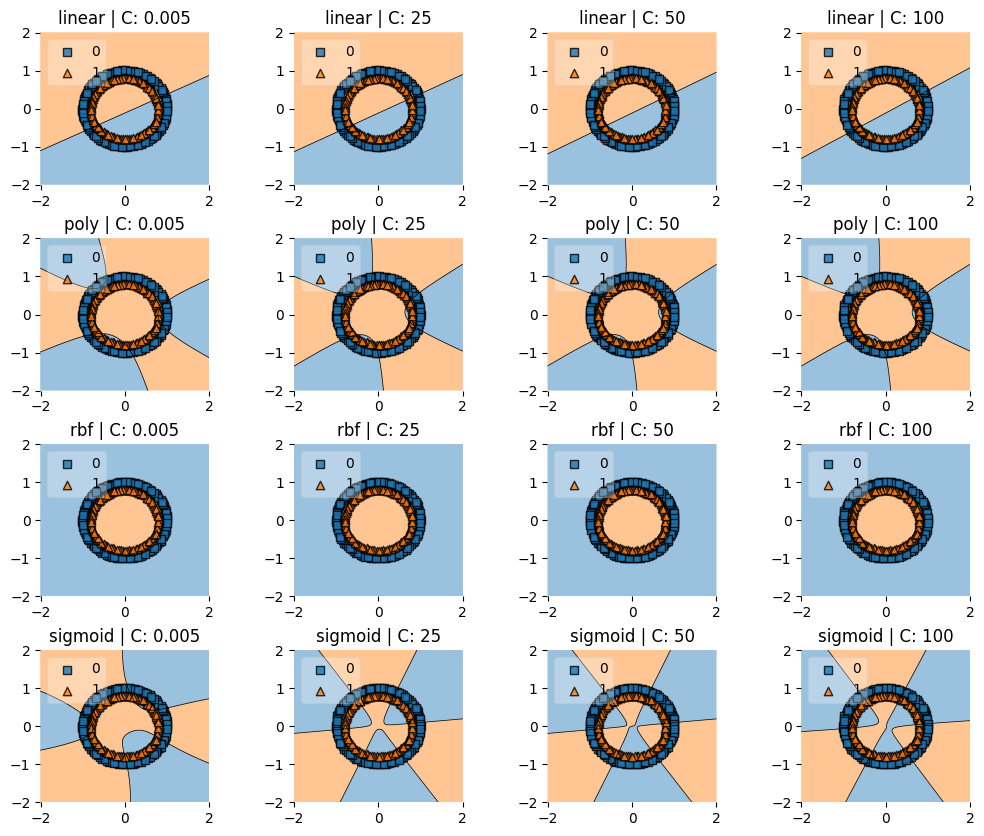

In [31]:
vis1 = VisualizeSVM(X1, y1, kernels, C, figsize=(12, 10), name="circles.png")
vis1.visualize()

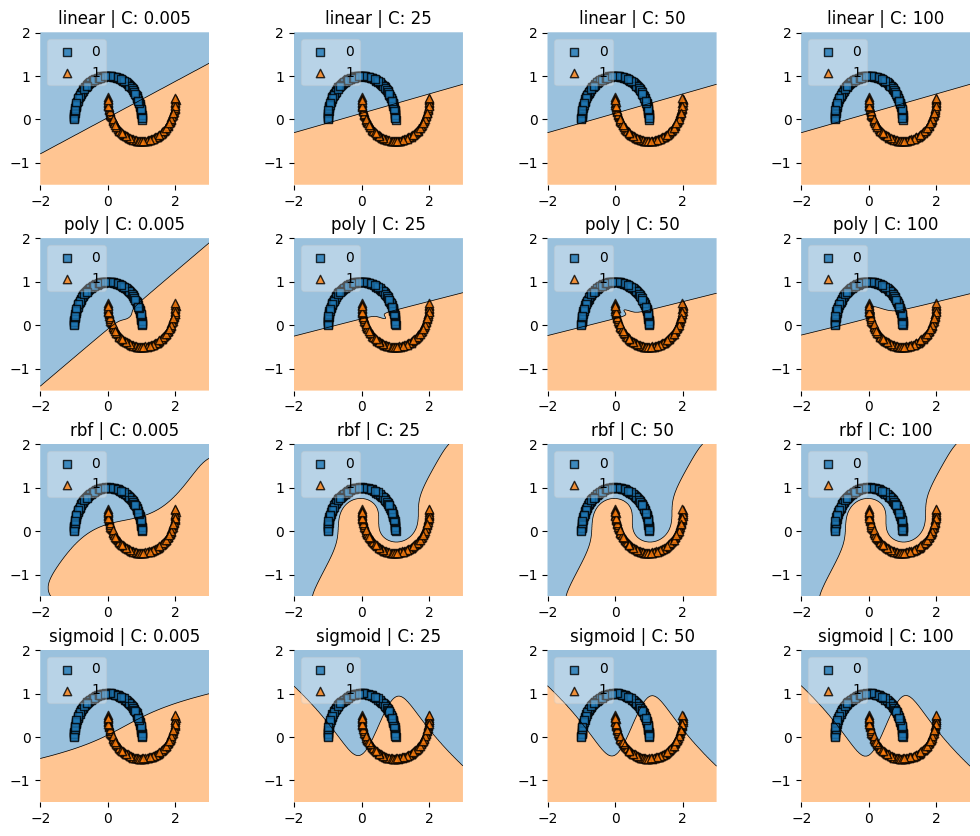

In [32]:
vis2 = VisualizeSVM(X2, y2, kernels, C, figsize=(12, 10), name="moons.png")
vis2.visualize()

To summarize, what we are seeing on both plots:
- Most flexible kernel is RBF based on the result
- Indeed linear does not work since the features are not linearly separable in our input space
- We can see that as we increase $C$, we allow less and less misclassification. Therefore, if our model is overfitted, then we might want to decrease $C$. On the other hand, if it is underfitting the data, then we should increase $C$.

If you want to read more about `RBF` kernel and its hyper-parameters, I suggest you read the following [note](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) which explains nicely the tradeoff between `C` and `gamma` (not used as hyper-parameter in my visualization)

> Comparing SVM classifier to other models

In this section, we will use the dataset on which we have tested all the classifiers in the past. This should give us a good overview of the difference between these classifiers and perhaps even some similarities. Let's first load the data and visualize it:

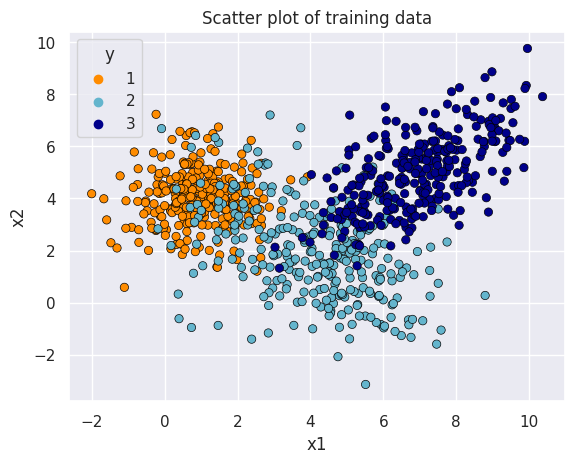

In [36]:
# Training
training = pd.read_csv("Ex1-training.csv")
X_train, y_train = training[["x1", "x2"]], training["y"]

# Test
test = pd.read_csv("Ex1-test.csv")
X_test, y_test = test[["x1", "x2"]], test["y"]

# Plot training
fig, ax = plt.subplots()
cmap_bold = ['darkorange', 'c', 'darkblue']
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_title("Scatter plot of training data");

Next, we can plot the decision regions for the selected models including `SVM`:

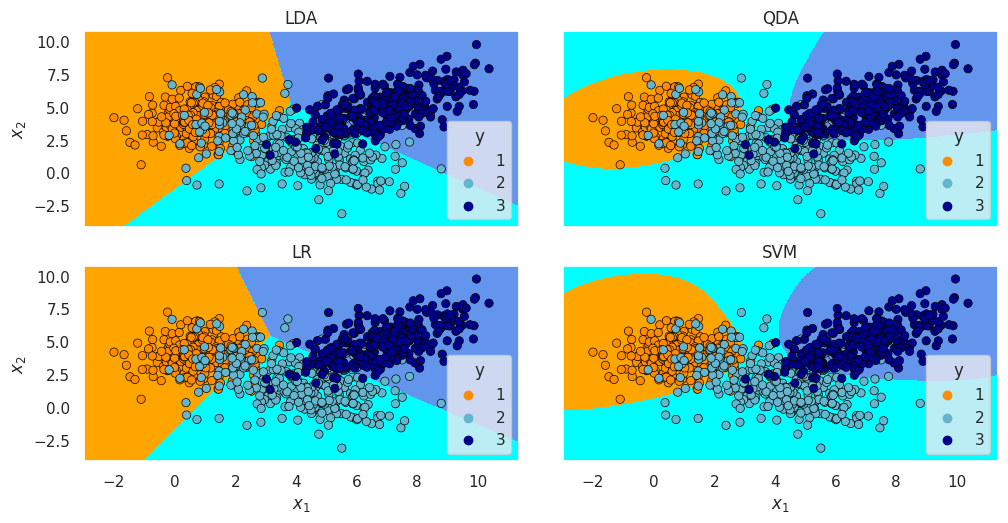

In [43]:
# Define plot 
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
plt.tight_layout();
fig.subplots_adjust(wspace=0.1, hspace=.2);

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Define classifiers
clfs = [[LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()],
        [LogisticRegression(), SVC()]]

# Define titles
titles = [["LDA", "QDA"], ["LR", "SVM"]]

# Mesh step
h = 0.02

for i in range(2):
    for j in range(2):
        
        # Get ax
        ax = axs[i, j]

        # Make the meshgrid
        x_min, x_max = X_train["x1"].min() - 1, X_train["x1"].max() + 1
        y_min, y_max = X_train["x2"].min() - 1, X_train["x2"].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Fit the model
        model = clfs[i][j].fit(X_train, y_train)
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        sns.scatterplot(x=X_train["x1"], y=X_train["x2"], hue=y_train, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
        ax.set_xlim(xx.min(), xx.max());
        ax.set_ylim(yy.min(), yy.max());
        ax.set_title(titles[i][j]);
        ax.set_xlabel("$x_1$");
        ax.set_ylabel("$x_2$");

Seems fairly similar to the `QDA` which makes sense since both are `non-linear`. On the opposite, we have the linear algorithms `LR` and `LDA` whose decision boundary is not that flexible. 

> Section summary

This section showed how `SVM` behaves using different `kernel functions` as well as reguralization parameter `C`. Therefore you should now be able to explain the impact of these hyper-parameters. Last but not the least, we compared `SVM` against other classifiers that we have discussed in this course, and found out that its decision boundary is quite similar to the `QDA` which we would expect given that our `SVM` model was using non-linear kernel `RBF`. With this, I conclude this session and also the topic of SVMs, have a nice weekend! 💫

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=34d52460-6a84-42a8-9f9e-5c6e57dab1cc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>